In [1]:
!pip install transformers tensorflow keras nltk gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [2]:
!pip install --upgrade numpy pandas gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 28.6 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [66]:
import pandas as pd
import numpy as np
import spacy
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import gensim
import gensim.downloader as api
from google.colab import drive

# Data Preprocessing & Labeling

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Load Dataset

In [73]:
df_reddit = pd.read_csv("/content/gdrive/MyDrive/reddit_avengers_doomsday_comments.csv")
df_youtube = pd.read_csv("/content/gdrive/MyDrive/youtube_avengers_doomsday_comments.csv")

df_reddit = df_reddit[["title", "comment", "source"]]
df_youtube = df_youtube[["title", "comment", "source"]]

df_merged = pd.concat([df_youtube, df_reddit], ignore_index=True)

## Labeling

In [74]:
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    batch_size=32
)

filtered_texts = []
filtered_labels = []

for i in tqdm(range(0, len(df_merged), 32)):
    batch_texts = df_merged["comment"].iloc[i:i+32].tolist()
    results = sentiment_analyzer(batch_texts, truncation=True, max_length=512)

    for result, text in zip(results, batch_texts):
        if result["score"] >= 0.8:
            filtered_texts.append(text)
            filtered_labels.append(result["label"])

# Create new filtered DataFrame
df_filtered = pd.DataFrame({
    "clean_comment": filtered_texts,
    "sentiment": filtered_labels
})

print("After filtering:")
print(df_filtered["sentiment"].value_counts())

Device set to use cuda:0


  0%|          | 0/918 [00:00<?, ?it/s]

After filtering:
sentiment
negative    3841
positive    3486
neutral      657
Name: count, dtype: int64


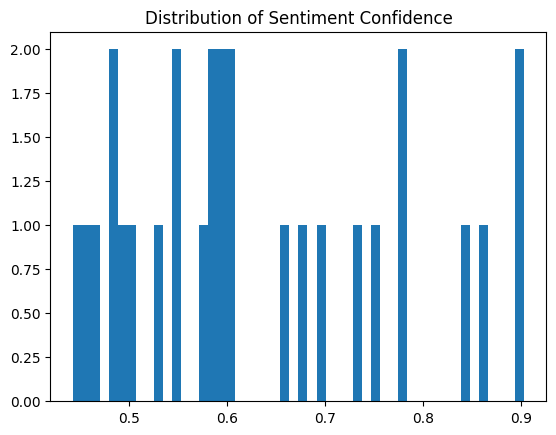

In [76]:
scores = [r['score'] for r in results]
plt.hist(scores, bins=50)
plt.title("Distribution of Sentiment Confidence")
plt.show()

In [78]:
df_filtered.head()

,clean_comment,sentiment
0,Congratulations RDJ is back,positive
1,Uma grande merda.,negative
2,Guys i dont understand one thing please someon...,negative
3,this movie is going to be epic,positive
4,SO EXCITED! 😲🎉🤯,positive


In [79]:
df_filtered.to_csv("processed_comments.csv", index=False)

# Model Training

## Feature Extraction

In [80]:
df = pd.read_csv("processed_comments.csv")

In [81]:
def extract_tfidf_features(texts, max_features=20000, ngram_range=(1, 3)):
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=3,
        max_df=0.85,
        sublinear_tf=True,
        norm='l2',
        use_idf=True,
        smooth_idf=True
    )
    X = vectorizer.fit_transform(texts)
    return X, vectorizer

In [82]:
def encode_labels(y):
    encoder = LabelEncoder()
    encoded_y = encoder.fit_transform(y)
    print(f"Encoded {len(np.unique(y))} classes: {dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))}")
    return encoded_y, encoder

## Data Splitting & Initialize Model

In [83]:
def train_and_evaluate_model(model, X, y, test_size=0.2, algorithm_name="", feature_method=""):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)

    print("="*60)
    print(f"Algorithm:        {algorithm_name}")
    print(f"Feature Method:   {feature_method}")
    print(f"Train/Test Split: {int((1 - test_size)*100)}/{int(test_size*100)}")
    print(f"Accuracy:          {acc:.4f}")
    print(classification_report(y_test, y_pred, digits=4))
    print("="*60)

In [84]:
X_tfidf, tfidf_vectorizer = extract_tfidf_features(df["clean_comment"])
y_encoded, label_encoder = encode_labels(df["sentiment"])

Encoded 3 classes: {'negative': 0, 'neutral': 1, 'positive': 2}


### Model Training

In [86]:
train_and_evaluate_model(SVC(kernel="linear", class_weight="balanced"), X_tfidf, y_encoded, test_size=0.2, algorithm_name="SVM", feature_method="TF-IDF")

Algorithm:        SVM
Feature Method:   TF-IDF
Train/Test Split: 80/20
Accuracy:          0.8798
              precision    recall  f1-score   support

           0     0.9025    0.8837    0.8930       765
           1     0.7381    0.6838    0.7099       136
           2     0.8809    0.9138    0.8970       696

    accuracy                         0.8798      1597
   macro avg     0.8405    0.8271    0.8333      1597
weighted avg     0.8791    0.8798    0.8792      1597



In [88]:
train_and_evaluate_model(RandomForestClassifier(n_estimators=500, max_depth=30, min_samples_split=5), X_tfidf, y_encoded, test_size=0.3, algorithm_name="Random Forest", feature_method="TF-IDF")

Algorithm:        Random Forest
Feature Method:   TF-IDF
Train/Test Split: 70/30
Accuracy:          0.8068
              precision    recall  f1-score   support

           0     0.8095    0.8530    0.8307      1136
           1     0.9559    0.3218    0.4815       202
           2     0.7949    0.8497    0.8214      1058

    accuracy                         0.8068      2396
   macro avg     0.8534    0.6748    0.7112      2396
weighted avg     0.8154    0.8068    0.7971      2396



# Model Training Deep Learning

## Feature Extraction

In [101]:
df = pd.read_csv("processed_comments.csv")

In [90]:
glove_model = api.load("glove-wiki-gigaword-300")

In [102]:
tokenizer = Tokenizer(num_words=10000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean_comment"])
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [103]:
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]

In [104]:
X = tokenizer.texts_to_sequences(df["clean_comment"])
maxlen = min(250, max([len(x) for x in X]))
X = pad_sequences(X, maxlen=maxlen, padding='post', truncating='post')
y = pd.get_dummies(df["sentiment"]).values

## Data Splitting

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Initialize deep learning model

In [109]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

In [110]:
model.compile(loss="categorical_crossentropy", optimizer="Adam", metrics=["accuracy"])

## Deep Learning Model Training

In [111]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=32
)

Epoch 1/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - accuracy: 0.5694 - loss: 0.8635 - val_accuracy: 0.8491 - val_loss: 0.4696
Epoch 2/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9123 - loss: 0.2746 - val_accuracy: 0.8867 - val_loss: 0.3208
Epoch 3/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9709 - loss: 0.0937 - val_accuracy: 0.8779 - val_loss: 0.3709
Epoch 4/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.9896 - loss: 0.0454 - val_accuracy: 0.8923 - val_loss: 0.4608
Epoch 5/5
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9916 - loss: 0.0328 - val_accuracy: 0.8873 - val_loss: 0.5621


In [126]:
loss, acc = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print("="*60)
print(f"Feature Method: Glove")
print(f"Model LSTM+CNN Accuracy: {acc:.4f}")
print(classification_report(y_test_labels, y_pred_labels))
print("="*60)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8892 - loss: 0.5381
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Feature Method: Glove
Model LSTM+CNN Accuracy: 0.8873
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       768
           1       0.82      0.67      0.74       132
           2       0.87      0.92      0.89       697

    accuracy                           0.89      1597
   macro avg       0.87      0.83      0.85      1597
weighted avg       0.89      0.89      0.89      1597



# Inference

In [124]:
sentiments = ["negative", "neutral", "positive"]  # Adjust if needed

def predict_sentiments(model, tokenizer, comments, maxlen=100):
    # Clean the comments (optional but recommended if your model was trained on cleaned text)
    def clean(text):
        text = text.lower()
        return " ".join(text.split())

    # Preprocess all comments
    cleaned_comments = [clean(comment) for comment in comments]
    sequences = tokenizer.texts_to_sequences(cleaned_comments)
    padded = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

    # Predict in batch
    predictions = model.predict(padded)

    # Get class predictions
    predicted_classes = np.argmax(predictions, axis=1)

    # Print output
    for comment, pred_idx, probs in zip(comments, predicted_classes, predictions):
        print(f"Comment: {comment}")
        print(f"Predicted Sentiment: {sentiments[pred_idx]} ({probs[pred_idx]:.2f} confidence)")
        print("=" * 60)


In [125]:
new_comments = [
    "Very excited for Avengers Doomsday",
    "Is that the official?",
    "Nope not interested"
]

predict_sentiments(model, tokenizer, new_comments)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Comment: Very excited for Avengers Doomsday
Predicted Sentiment: positive (1.00 confidence)
Comment: Is that the official?
Predicted Sentiment: neutral (0.97 confidence)
Comment: Nope not interested
Predicted Sentiment: negative (1.00 confidence)


# Evaluate

*   SVM with TF-IDF, 80/20 split, Accuracy: 0.8798
*   Random Forest with TF-IDF, 70/30 split, Accuracy: 0.8068
*   Model LSTM+CNN with Glove, 80/20 split, Accuracy: 0.8873
*   Neutral class is are low since the its only about 5%
*   Positive class being the best.







